# **Bank Marketing**

Program ini dibuat untuk menganalisa dan memprediksi pembelian produk deposito berdasarkan kampanye marketing pada sebuah bank di Portugal. Model yang digunakan terdiri dari 5 model, yaitu SVM, KNN, Decision Tree, Random Forest dan XGBoost. Model-model tersebut akan diuji dan kemudian dipilih berdasarkan performanya dalam mendeteksi pelanggan yang berpotensi menerima penawaran marketing untuk membeli produk deposito. Langkah perbaikan juga akan dilakukan apabila performa model dirasa kurang baik sehingga performa model dapat meningkat.
  
  
URL Dashboard Tableau: https://public.tableau.com/app/profile/lungun.ali.rusky.simbolon/viz/BankMarketing_17171615728830/Dashboard1
  
Sumber Data :  
https://archive.ics.uci.edu/dataset/222/bank+marketing  
  [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001

---

### **Keterangan Data**

|Variable|Description|
|---|---|
Age|Age|
Job|Type of job|
Marital|Marital status|
Education|Education Level|
Default|Has credit in default?|
Balance|Average yearly balance|
Housing|Has housing loan?|
Loan|Has personal loan?|
Contact|Contact communication type|
Day|Last contact day of the month|
Month|Last contact month of year|
Duration|Last contact duration, in seconds|
Campaign|Number of contacts performed during this campaign and for this client|
Pdays|Number of days that passed by after the client was last contacted from a previous campaign, -1 means client was not previously contacted|
Previous|number of contacts performed before this campaign and for this client|
Poutcome|outcome of the previous marketing campaign|
y|has the client subscribed a term deposit?|

# **Import Libraries**

In [1]:
'''Loading tools yang dibutuhkan untuk analisa'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
import pickle 
import json
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, roc_curve

C:\Users\asus\AppData\Local\Temp\ipykernel_5732\4181132912.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# **Data Loading**

In [2]:
'''Import data dari csv'''

df = pd.read_csv('bank-full.csv', delimiter=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
'''Mengecek apakah ada data yang null'''
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [4]:
'''Menampilkan informasi umum dari tabel yang sudah di impor'''

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# **Feature Engineering**

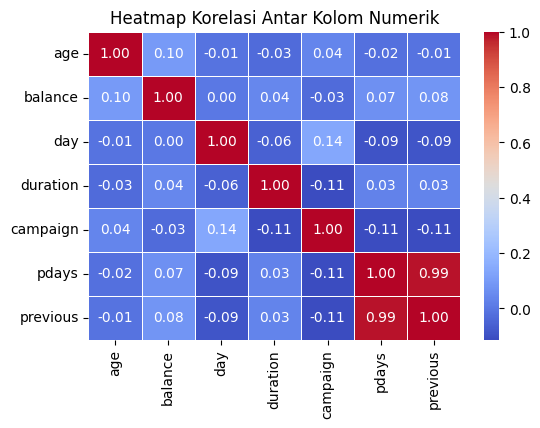

In [46]:
'''Menghitung korelasi antar kolom numerik terhadap kolom target (y_encoded)'''

# Memilih kolom-kolom numerik
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
numeric_data = df[numeric_columns]

# Menghitung korelasi antar kolom menggunakan korelasi Spearman
correlation_spearman = numeric_data.corr(method='spearman')

# Membuat heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Antar Kolom Numerik')
plt.show()

Perhitungan pada kolom menurik menggunakan metode Spearman divisualisasikan dalam bentuk heatmap. Grafik tersebut menunjukkan nilai-nilai korelasi antar kolom. Kolom yang akan menjadi target adalah kolom y_encoded dimana kolom ini adalah kolom hasil respon nasabah yang diberikan kampanye deposito. Berdasarkan hasil tersebut maka kolom yang akan digunakan dalam model machine learning adalah kolom :  
  
* previous (0,17)
* pdays (0,15)
* duration (0.34)

In [47]:
'''Menghitung korelasi antar kolom kategorikal dengan kolom y menggunakan chi square test dan p-value'''

# Kolom target
target_column = 'y'

# Pilih hanya kolom-kolom kategorikal
categorical_columns = df.select_dtypes(include=['object']).columns

# Melakukan uji chi-square untuk setiap pasangan kolom kategorikal dengan kolom target
for col in categorical_columns:
    if col != target_column:
        # Membuat tabel kontingensi
        contingency_table = pd.crosstab(df[col], df[target_column])
        
        # Melakukan uji chi-square
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        # Menampilkan hasil uji chi-square
        print(f"Uji Chi-square antara kolom '{col}' dan '{target_column}':")
        print(f"Chi-square statistic: {chi2}")
        print(f"P-value: {p}")
        print("\n")

Uji Chi-square antara kolom 'job' dan 'y':
Chi-square statistic: 836.1054877471965
P-value: 3.337121944935502e-172


Uji Chi-square antara kolom 'marital' dan 'y':
Chi-square statistic: 196.49594565603957
P-value: 2.1450999986791792e-43


Uji Chi-square antara kolom 'education' dan 'y':
Chi-square statistic: 238.92350616407606
P-value: 1.6266562124072994e-51


Uji Chi-square antara kolom 'default' dan 'y':
Chi-square statistic: 22.20224995571685
P-value: 2.4538606753508344e-06


Uji Chi-square antara kolom 'housing' dan 'y':
Chi-square statistic: 874.822448867983
P-value: 2.918797605076633e-192


Uji Chi-square antara kolom 'loan' dan 'y':
Chi-square statistic: 209.61698034978633
P-value: 1.665061163492756e-47


Uji Chi-square antara kolom 'contact' dan 'y':
Chi-square statistic: 1035.714225356292
P-value: 1.251738325340638e-225


Uji Chi-square antara kolom 'month' dan 'y':
Chi-square statistic: 3061.838938445269
P-value: 0.0


Uji Chi-square antara kolom 'poutcome' dan 'y':
Chi-squar

Hasil perhitungan diatas menunjukkan nilai korelasi antar kolom pada data bertipe kategorikal. Berdasarkan hasil tersebut didapatkan rata-rata kolom memiliki nilai P-value < 0,05 sehingga bisa dikatakan setiap kolom memiliki korelasi yang signifikan. Secara urutan didapatkan korelasi antar kolom dengan nilai terkuat :
* poutcome
* month
* contact
* housing
* job
* loan
* education
* marital  
  
kolom-kolom tersebut akan digunakan dalam model pada proses machine learning.

In [7]:
'''Memilih kolom yang akan digunakan berdasarkan perhitungan nilai korelasi'''

selected_columns = df[['previous', 'pdays', 'duration', 'poutcome', 'month', 'contact', 'housing', 'job', 'loan', 'education', 'marital', 'y']]

df1 = pd.DataFrame(selected_columns)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   previous   45211 non-null  int64 
 1   pdays      45211 non-null  int64 
 2   duration   45211 non-null  int64 
 3   poutcome   45211 non-null  object
 4   month      45211 non-null  object
 5   contact    45211 non-null  object
 6   housing    45211 non-null  object
 7   job        45211 non-null  object
 8   loan       45211 non-null  object
 9   education  45211 non-null  object
 10  marital    45211 non-null  object
 11  y          45211 non-null  object
dtypes: int64(3), object(9)
memory usage: 4.1+ MB


In [9]:
'''Cek ada tidaknya missing value di data'''

df1.isna().sum()

previous     0
pdays        0
duration     0
poutcome     0
month        0
contact      0
housing      0
job          0
loan         0
education    0
marital      0
y            0
dtype: int64

In [10]:
'''Mengubah kolom y yang isinya kategorikal menjadi numerikal'''
df1['y_encoded'] = df1['y'].map({'yes': 1, 'no': 0})

In [11]:
# Menghapus kolom 'y' dari DataFrame df1
df1.drop('y', axis=1, inplace=True)

# Split Data

In [12]:
'''Splitting dilakukan dengan menjadikan response sebagai target karena kita ingin mengetahui respon dari pelanggan, apakah menerima
penawaran atau tidak'''

X = df1.drop(['y_encoded'], axis=1)
y = df1.y_encoded

X.head()

,previous,pdays,duration,poutcome,month,contact,housing,job,loan,education,marital
0,0,-1,261,unknown,may,unknown,yes,management,no,tertiary,married
1,0,-1,151,unknown,may,unknown,yes,technician,no,secondary,single
2,0,-1,76,unknown,may,unknown,yes,entrepreneur,yes,secondary,married
3,0,-1,92,unknown,may,unknown,yes,blue-collar,no,unknown,married
4,0,-1,198,unknown,may,unknown,no,unknown,no,unknown,single


### Split Data Train dan Test

In [13]:
''' Melakukan spliting antara train, test dan inference'''

# Bagi data menjadi train (70%) dan sisa (30% untuk test dan inference)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=32)
print('Train Size: ', X_train.shape)

# Bagi sisa menjadi test (5/30 dari sisa yaitu 5% dari total) dan inference (25/30 dari sisa yaitu 25% dari total)
X_test, X_inference, y_test, y_inference = train_test_split(X_temp, y_temp, test_size=5/30, random_state=32)
print('Test Size: ', X_test.shape)
print('Inference Size: ', X_inference.shape)

# Gabungkan fitur dan target untuk data inference
inference_data = pd.concat([X_inference, y_inference], axis=1)

Train Size:  (31647, 11)
Test Size:  (11303, 11)
Inference Size:  (2261, 11)


In [14]:
# Simpan data inference ke dalam file CSV
inference_data.to_csv('inference_data.csv', index=False)
print('Inference data saved to inference_data.csv')

Inference data saved to inference_data.csv


# **Model Definition**

In [15]:
'''Pengelompokkan kolom kategorikal dan numerikal'''
column_cat = ['poutcome','month','contact','housing','job','loan','education','marital']
column_num = ['previous','pdays','duration']

### KNN

In [16]:
# Membuat pipeline untuk KNN
knn_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), column_num),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), column_cat)
        ])),
    ('knn', KNeighborsClassifier())
])

print('Pipeline steps : ', knn_pipeline.steps)


Pipeline steps :  [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['previous', 'pdays', 'duration']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['poutcome', 'month', 'contact', 'housing',
                                  'job', 'loan', 'education', 'marital'])])), ('knn', KNeighborsClassifier())]


### SVM

In [17]:
# Definisikan pipeline untuk SVM
svm_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), column_num),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), column_cat)
        ])),
    ('svm', SVC())
])

print('Pipeline steps : ', svm_pipeline.steps)

Pipeline steps :  [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['previous', 'pdays', 'duration']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['poutcome', 'month', 'contact', 'housing',
                                  'job', 'loan', 'education', 'marital'])])), ('svm', SVC())]


### Decision Tree

In [18]:
# Definisikan pipeline untuk SVM
dt_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), column_num),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), column_cat)
        ])),
    ('dt', DecisionTreeClassifier())
])

print('Pipeline steps : ', dt_pipeline.steps)

Pipeline steps :  [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['previous', 'pdays', 'duration']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['poutcome', 'month', 'contact', 'housing',
                                  'job', 'loan', 'education', 'marital'])])), ('dt', DecisionTreeClassifier())]


### Random Forest

In [19]:
# Definisikan pipeline untuk SVM
rf_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), column_num),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), column_cat)
        ])),
    ('rf', RandomForestClassifier())
])

print('Pipeline steps : ', rf_pipeline.steps)

Pipeline steps :  [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['previous', 'pdays', 'duration']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['poutcome', 'month', 'contact', 'housing',
                                  'job', 'loan', 'education', 'marital'])])), ('rf', RandomForestClassifier())]


### XGBoost

In [20]:
# Definisikan pipeline untuk XGBoost

xgb_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), column_num),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), column_cat)
        ])),
    ('xgb', XGBClassifier())
])

print('Pipeline steps : ', xgb_pipeline.steps)

Pipeline steps :  [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['previous', 'pdays', 'duration']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['poutcome', 'month', 'contact', 'housing',
                                  'job', 'loan', 'education', 'marital'])])), ('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
         

# **Pipeline**

### KNN

In [21]:
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['previous', 'pdays',
                                                   'duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['poutcome', 'month',
                                                   'contact', 'housing', 'job',
                                                   'loan', 'education',
                                                   'marital'])])),
                ('knn', KNeighborsClassifier())])

### SVM

In [22]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['previous', 'pdays',
                                                   'duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['poutcome', 'month',
                                                   'contact', 'housing', 'job',
                                                   'loan', 'education',
                                                   'marital'])])),
                ('svm', SVC())])

### Decision Tree

In [23]:
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['previous', 'pdays',
                                                   'duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['poutcome', 'month',
                                                   'contact', 'housing', 'job',
                                                   'loan', 'education',
                                                   'marital'])])),
                ('dt', DecisionTreeClassifier())])

### Random Forest

In [24]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['previous', 'pdays',
                                                   'duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['poutcome', 'month',
                                                   'contact', 'housing', 'job',
                                                   'loan', 'education',
                                                   'marital'])])),
                ('rf', RandomForestClassifier())])

### XGBoost

In [25]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['previous', 'pdays',
                                                   'duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['poutcome', 'month',
                                                   'contact', 'housing', 'job',
                                                   'loan', 'education',
                                                   'marital'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

# **Model Evaluation**

### KNN Predict & Evaluation

In [26]:
# Predict Train-set and Test-set
y_pred_train_knn = knn_pipeline.predict(X_train)
y_pred_test_knn = knn_pipeline.predict(X_test)

# Print classification report
print('Classification Report KNN Train: ')
print(classification_report(y_train, y_pred_train_knn))
print('Classification Report KNN Test: ')
print(classification_report(y_test, y_pred_test_knn))

Classification Report KNN Train: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     27915
           1       0.75      0.52      0.61      3732

    accuracy                           0.92     31647
   macro avg       0.84      0.75      0.79     31647
weighted avg       0.92      0.92      0.92     31647

Classification Report KNN Test: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10011
           1       0.57      0.38      0.46      1292

    accuracy                           0.90     11303
   macro avg       0.75      0.67      0.70     11303
weighted avg       0.88      0.90      0.89     11303



### SVM Predict & Evaluation

In [27]:
# Predict Train-set and Test-set
y_pred_train_svm = svm_pipeline.predict(X_train)
y_pred_test_svm = svm_pipeline.predict(X_test)

# Print classification report
print('Classification Report SVM Train: ')
print(classification_report(y_train, y_pred_train_svm))
print('Classification Report SVM Test: ')
print(classification_report(y_test, y_pred_test_svm))

Classification Report SVM Train: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     27915
           1       0.75      0.42      0.53      3732

    accuracy                           0.91     31647
   macro avg       0.84      0.70      0.74     31647
weighted avg       0.91      0.91      0.90     31647

Classification Report SVM Test: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10011
           1       0.66      0.36      0.46      1292

    accuracy                           0.91     11303
   macro avg       0.79      0.67      0.71     11303
weighted avg       0.89      0.91      0.89     11303



### Decision Tree Prediction & Evaluation

In [28]:
# Predict Train-set and Test-set
y_pred_train_dt = dt_pipeline.predict(X_train)
y_pred_test_dt = dt_pipeline.predict(X_test)

# Print classification report
print('Classification Report Decision Tree Train: ')
print(classification_report(y_train, y_pred_train_dt))
print('Classification Report Decision Tree Test: ')
print(classification_report(y_test, y_pred_test_dt))

Classification Report Decision Tree Train: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27915
           1       1.00      0.99      1.00      3732

    accuracy                           1.00     31647
   macro avg       1.00      1.00      1.00     31647
weighted avg       1.00      1.00      1.00     31647

Classification Report Decision Tree Test: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10011
           1       0.44      0.45      0.44      1292

    accuracy                           0.87     11303
   macro avg       0.68      0.69      0.69     11303
weighted avg       0.87      0.87      0.87     11303



### Random Forest Prediction & Evaluation

In [29]:
# Predict Train-set and Test-set
y_pred_train_rf = rf_pipeline.predict(X_train)
y_pred_test_rf = rf_pipeline.predict(X_test)

# Print classification report
print('Classification Report Random Forest Train: ')
print(classification_report(y_train, y_pred_train_rf))
print('Classification Report Random Forest Test: ')
print(classification_report(y_test, y_pred_test_rf))

Classification Report Random Forest Train: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27915
           1       1.00      0.99      1.00      3732

    accuracy                           1.00     31647
   macro avg       1.00      1.00      1.00     31647
weighted avg       1.00      1.00      1.00     31647

Classification Report Random Forest Test: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10011
           1       0.54      0.43      0.48      1292

    accuracy                           0.89     11303
   macro avg       0.73      0.69      0.71     11303
weighted avg       0.88      0.89      0.89     11303



### XGBoost Prediction & Evaluation

In [30]:
# Predict Train-set and Test-set
y_pred_train_xgb = xgb_pipeline.predict(X_train)
y_pred_test_xgb = xgb_pipeline.predict(X_test)

# Print classification report
print('Classification Report XGBoost Train: ')
print(classification_report(y_train, y_pred_train_xgb))
print('Classification Report XGBoost Test: ')
print(classification_report(y_test, y_pred_test_xgb))

Classification Report XGBoost Train: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27915
           1       0.82      0.63      0.71      3732

    accuracy                           0.94     31647
   macro avg       0.89      0.81      0.84     31647
weighted avg       0.94      0.94      0.94     31647

Classification Report XGBoost Test: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     10011
           1       0.60      0.46      0.52      1292

    accuracy                           0.90     11303
   macro avg       0.77      0.71      0.73     11303
weighted avg       0.89      0.90      0.90     11303



### **Interpretasi Hasil Evaluasi**

### **KNN (K-Nearest Neighbors):**  
  
**Train:**  
* Precision (0): 94%, Recall (0): 98%  
* Precision (1): 75%, Recall (1): 52%  
* Accuracy: 92%  
* F1-score (1): 61%  

**Test:**  
* Precision (0): 92%, Recall (0): 96%  
* Precision (1): 57%, Recall (1): 38%  
* Accuracy: 90%  
* F1-score (1): 46%  

**Interpretasi:**  
Model KNN bekerja dengan baik dengan skor 92% pada data latih namun mengalami penurunan pada data uji menjadi 90%. Hasil yang ditunjukkan cenderung overfit karena skor pada data uji yang turun jauh dari data laithnya.  Model ini mampu memprediksi kelas mayoritas "0" (orang yang tidak membeli deposito) dengan baik, namun untuk kelas minoritas "1" (orang yang membeli deposito) hasilnya rendah baik pada data latih maupun data uji. Ini berarti model cenderung melewatkan calon pelanggan yang potensial.
  
  
### **SVM (Support Vector Machine):**

**Train:**
* Precision (0): 93%, Recall (0): 98%  
* Precision (1): 75%, Recall (1): 42%  
* Accuracy: 91%  
* F1-score (1): 53%  

**Test:**  
* Precision (0): 92%, Recall (0): 98%  
* Precision (1): 66%, Recall (1): 36%  
* Accuracy: 91%  
* F1-score (1): 46%  

**Interpretasi:**  
SVM juga menunjukkan kinerja yang baik dimana akurasinya konsisten di 91% pada data latih maupun data uji. Model ini cenderung well-fit karena hasilnya yang tidak terlalu berbeda jauh dan konsisten antara data latih dan uji. Sama seperti model KNN, model ini kesulitan untuk memprediksi kelasi minoritas.  Model ini cenderung lebih banyak melewatkan orang yang sebenarnya akan membeli deposito.

  
### **Decision Tree:**
  
**Train:**  
* Precision (0): 100%, Recall (0): 100%  
* Precision (1): 100%, Recall (1): 99%  
* Accuracy: 100%  
* F1-score (1): 100%  

**Test:**  
* Precision (0): 93%, Recall (0): 92%  
* Precision (1): 44%, Recall (1): 46%  
* Accuracy: 87%  
* F1-score (1): 45%  

**Interpretasi:**  
Decision Tree terlihat sangat overfit pada data latih dengan akurasi 100%, namun performanya menurun signifikan pada data uji menjadi 87%. Recall pada kelas "1" hanya 46%, menunjukkan bahwa model masih melewatkan sejumlah besar calon pelanggan potensial pada data uji.
  
  
### **Random Forest:**

**Train:**
* Precision (0): 100%, Recall (0): 100%  
* Precision (1): 100%, Recall (1): 99%  
* Accuracy: 100%  
* F1-score (1): 100%  

**Test:**
* Precision (0): 93%, Recall (0): 95%  
* Precision (1): 53%, Recall (1): 42%  
* Accuracy: 89%  
* F1-score (1): 47%  

**Interpretasi:**  
Model Random Forest menunjukkan pola yang serupa dengan Decision Tree, kinerja yang sempurna pada data latih namun menurun hingga 89% pada data uji. Recall pada kelas minoritas hanya 42% pada data uji, menunjukkan bahwa model masih kurang baik dalam mendeteksi calon pelanggan yang potensial.  
  
  
### **XGBoost:**  
  
**Train:**  
* Precision (0): 95%, Recall (0): 98%  
* Precision (1): 82%, Recall (1): 63%  
* Accuracy: 94%  
* F1-score (1): 71%  

**Test:**  
* Precision (0): 93%, Recall (0): 96%  
* Precision (1): 60%, Recall (1): 46%  
* Accuracy: 90%  
* F1-score (1): 52%  

**Interpretasi:**  
XGBoost menunjukkan keseimbangan yang lebih baik antara precision dan recall, khususnya pada kelas "1". Dengan recall 46% pada data uji, model ini lebih baik dalam mendeteksi calon pelanggan potensial dibandingkan model lain, meskipun masih ada ruang untuk perbaikan.  

### **Kesimpulan:**
Nilai recall menjadi penting ketika kita ingin memastikan tidak melewatkan calon pelanggan potensial. Karena Recall menunjukkan kemampuan model untuk mengidentifikasi semua contoh positif dengan benar, dengan kata lain Recall mengingdikasikan seberapa baik model dapat mendeteksi semua orang yang benar-benar akan membeli produk deposito.

Model Terbaik: Dari model yang diuji, XGBoost menunjukkan performa terbaik dengan recall yang cukup tinggi pada kelas minoritas "1" baik pada data latih maupun data uji. Meskipun masih ada ruang untuk perbaikan, model ini lebih mampu dalam mendeteksi calon pelanggan potensial dibandingkan model lainnya.

# **Cross Validation**

### KNN

In [31]:
#Cross Validation KNN

knn_prc_train_cross_val = cross_val_score(knn_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('KNN Recall Score - All - Cross Validation  : ', knn_prc_train_cross_val)
print('KNN Recall Score - Mean - Cross Validation : ', knn_prc_train_cross_val.mean())
print('KNN Recall Score - Std - Cross Validation  : ', knn_prc_train_cross_val.std())
print('KNN Recall Score - Range of Test-Set       : ', (knn_prc_train_cross_val.mean()-knn_prc_train_cross_val.std()) , '-', (knn_prc_train_cross_val.mean()+knn_prc_train_cross_val.std()))

KNN Recall Score - All - Cross Validation  :  [0.39308682 0.38424437 0.37620579]
KNN Recall Score - Mean - Cross Validation :  0.3845123258306538
KNN Recall Score - Std - Cross Validation  :  0.006894255268096787
KNN Recall Score - Range of Test-Set       :  0.37761807056255703 - 0.3914065810987506


### SVM

In [32]:
#Cross Validation SVM

svm_prc_train_cross_val = cross_val_score(svm_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('SVM Recall Score - All - Cross Validation  : ', svm_prc_train_cross_val)
print('SVM Recall Score - Mean - Cross Validation : ', svm_prc_train_cross_val.mean())
print('SVM Recall Score - Std - Cross Validation  : ', svm_prc_train_cross_val.std())
print('SVM Recall Score - Range of Test-Set       : ', (svm_prc_train_cross_val.mean()-svm_prc_train_cross_val.std()) , '-', (svm_prc_train_cross_val.mean()+svm_prc_train_cross_val.std()))

SVM Recall Score - All - Cross Validation  :  [0.36655949 0.3488746  0.35530547]
SVM Recall Score - Mean - Cross Validation :  0.3569131832797428
SVM Recall Score - Std - Cross Validation  :  0.007308779044472588
SVM Recall Score - Range of Test-Set       :  0.3496044042352702 - 0.3642219623242154


### Decision Tree

In [33]:
#Cross Validation Decision Tree

dt_prc_train_cross_val = cross_val_score(dt_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('Decision Tree Recall Score - All - Cross Validation  : ', dt_prc_train_cross_val)
print('Decision Tree Recall Score - Mean - Cross Validation : ', dt_prc_train_cross_val.mean())
print('Decision Tree Recall Score - Std - Cross Validation  : ', dt_prc_train_cross_val.std())
print('Decision Tree Recall Score - Range of Test-Set       : ', (dt_prc_train_cross_val.mean()-dt_prc_train_cross_val.std()) , '-', (dt_prc_train_cross_val.mean()+dt_prc_train_cross_val.std()))

Decision Tree Recall Score - All - Cross Validation  :  [0.46543408 0.4670418  0.47266881]
Decision Tree Recall Score - Mean - Cross Validation :  0.4683815648445873
Decision Tree Recall Score - Std - Cross Validation  :  0.003101778376953431
Decision Tree Recall Score - Range of Test-Set       :  0.4652797864676339 - 0.47148334322154073


### Random Forest

In [34]:
#Cross Validation Random Forest

rf_prc_train_cross_val = cross_val_score(rf_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('Random Forest Recall Score - All - Cross Validation  : ', rf_prc_train_cross_val)
print('Random Forest Recall Score - Mean - Cross Validation : ', rf_prc_train_cross_val.mean())
print('Random Forest Recall Score - Std - Cross Validation  : ', rf_prc_train_cross_val.std())
print('Random Forest Recall Score - Range of Test-Set       : ', (rf_prc_train_cross_val.mean()-rf_prc_train_cross_val.std()) , '-', (rf_prc_train_cross_val.mean()+rf_prc_train_cross_val.std()))

Random Forest Recall Score - All - Cross Validation  :  [0.45498392 0.45096463 0.45096463]
Random Forest Recall Score - Mean - Cross Validation :  0.45230439442658094
Random Forest Recall Score - Std - Cross Validation  :  0.0018947127041440252
Random Forest Recall Score - Range of Test-Set       :  0.4504096817224369 - 0.454199107130725


### XGBoost

In [35]:
#Cross Validation XGBoost

xgb_prc_train_cross_val = cross_val_score(xgb_pipeline,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('XGBoost Recall Score - All - Cross Validation  : ', xgb_prc_train_cross_val)
print('XGBoost Recall Score - Mean - Cross Validation : ', xgb_prc_train_cross_val.mean())
print('XGBoost Recall Score - Std - Cross Validation  : ', xgb_prc_train_cross_val.std())
print('XGBoost Recall Score - Range of Test-Set       : ', (xgb_prc_train_cross_val.mean()-xgb_prc_train_cross_val.std()) , '-', (xgb_prc_train_cross_val.mean()+xgb_prc_train_cross_val.std()))

XGBoost Recall Score - All - Cross Validation  :  [0.49276527 0.46543408 0.46061093]
XGBoost Recall Score - Mean - Cross Validation :  0.4729367631296892
XGBoost Recall Score - Std - Cross Validation  :  0.014158461750935596
XGBoost Recall Score - Range of Test-Set       :  0.4587783013787536 - 0.4870952248806248


### **Interpetasi Cross Validation**
  
**KNN (K-Nearest Neighbors)**  
* Recall Score - All - Cross Validation: [0.39308682, 0.38424437, 0.37620579]  
* Mean Recall: 0.3845  
* Standard Deviation: 0.0069  
* Range of Test-Set: 0.3776 - 0.3914  

**Interpretasi:**  
KNN menunjukkan recall yang cukup rendah dengan nilai rata-rata 0.3845. Ini berarti model KNN kurang baik dalam mendeteksi pelanggan yang akan membeli produk deposito. Stabilitasnya cukup baik terlihat dari rentang recall yang sempit.  
  
  
**SVM (Support Vector Machine)**  
* Recall Score - All - Cross Validation: [0.36655949, 0.3488746, 0.35530547]  
* Mean Recall: 0.3569  
* Standard Deviation: 0.0073  
* Range of Test-Set: 0.3496 - 0.3642  

**Interpretasi:** 
SVM menunjukkan recall yang lebih rendah dibandingkan KNN dengan nilai rata-rata 0.3569. Sama seperti KNN, model ini juga tidak terlalu efektif dalam mendeteksi pelanggan yang akan membeli produk deposito dengan skor standar variasi yang sedikit lebih tinggi.  
  
  
**Decision Tree**
* Recall Score - All - Cross Validation: [0.45819936, 0.46382637, 0.47186495]  
* Mean Recall: 0.4646  
* Standard Deviation: 0.0056  
* Range of Test-Set: 0.4590 - 0.4702  

**Interpretasi:**  
Decision Tree menunjukkan performa yang lebih baik dengan nilai recall rata-rata 0.4646. Model Decision Tree cenderung lebih efektif dalam mendeteksi pelanggan yang akan membeli produk deposito. Stabilitasnya juga cukup baik dengan rentang yang sempit.  
  
  
**Random Forest**  
* Recall Score - All - Cross Validation: [0.45337621, 0.43729904, 0.4477492]  
* Mean Recall: 0.4461  
* Standard Deviation: 0.0067  
* Range of Test-Set: 0.4395 - 0.4528  

**Interpretasi:**
Random Forest juga menunjukkan performa yang baik dengan recall rata-rata 0.4461, mendekati Decision Tree. Model Random Forest cukup efektif dalam mendeteksi pelanggan yang akan membeli produk deposito dengan variasi skor yang sedikit lebih tinggi.  
  
  
**XGBoost**
* Recall Score - All - Cross Validation: [0.49276527, 0.46543408, 0.46061093]  
* Mean Recall: 0.4729  
* Standard Deviation: 0.0142  
* Range of Test-Set: 0.4588 - 0.4871  

**Interpretasi:**
XGBoost menunjukkan performa terbaik dengan recall rata-rata 0.4729, hal ini menunjukkan bahwa XGBoost adalah model yang paling efektif dalam mendeteksi pelanggan yang akan membeli produk deposito. Model ini memang efektif untuk mendeteksi kelas minoritas namun variasi skornya juga lebih besar dibandingkan model lain yang mana menunjukkan sedikit ketidakstabilan.  
  
  
  
### **Kesimpulan**
* XGBoost dengan recall rata-rata 0.4729, menunjukkan bahwa model ini paling efektif dalam mendeteksi pelanggan yang akan membeli produk deposito.  
* Model Alternatif: Decision Tree (recall 0.4646) dan Random Forest (recall 0.4461) juga menunjukkan performa yang cukup baik dan bisa dipertimbangkan sebagai alternatif.  
* Model yang Kurang Efektif: KNN dan SVM memiliki recall yang lebih rendah (masing-masing 0.3845 dan 0.3569) dan kurang efektif dalam mendeteksi pelanggan yang akan membeli produk deposito.  
  
Berdasarkan hasil di atas, XGBoost adalah model yang paling direkomendasikan untuk digunakan dalam mendeteksi pelanggan yang berpotensi menerima kampanye marketing dan membeli produk deposito. Decision Tree dan Random Forest juga dapat dipertimbangkan jika diperlukan model alternatif dengan stabilitas yang sedikit lebih tinggi.

# **Model Improvement**

### Hyperparameter Tuning

Model Improvement yang akan diterapkan adalah dengan melakukan Hyperparameter tuning untuk mencari parameter terbaik dan juga melakukan oversampling dengan metode SMOTE untuk meningkatkan pengenalan model pada kelas minoritas. Langkah yang akan dilakukan terlebih dahulu adalah mengecek proporsi kelas minoritas dan mayoritas untuk memastikan apakah terdapat indikasi imbalance pada data. Berikutnya adalah melakukan tuning dan juga oversampling jika memang dirasa datanya imbalance.

In [36]:
# Definisikan pipeline untuk XGBoost
xgb_pipeline_tuning = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), column_num),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), column_cat)
        ])),
    ('xgb', XGBClassifier())
])

print('Pipeline steps : ', xgb_pipeline_tuning.steps)

xgb_pipeline_tuning.fit(X_train,y_train)

Pipeline steps :  [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['previous', 'pdays', 'duration']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['poutcome', 'month', 'contact', 'housing',
                                  'job', 'loan', 'education', 'marital'])])), ('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
         

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['previous', 'pdays',
                                                   'duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['poutcome', 'month',
                                                   'contact', 'housing', 'job',
                                                   'loan', 'education',
                                                   'marital'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [37]:
# Definisikan parameter grid untuk tuning
param_grid_tuning = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 6, 9],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2]
}

# Definisikan GridSearchCV
xgb_grid_tuning = GridSearchCV(estimator=xgb_pipeline_tuning, param_grid=param_grid_tuning, cv=3, verbose=1, n_jobs=-1, scoring='recall')

# Fit GridSearchCV
xgb_grid_tuning.fit(X_train, y_train)

# Dapatkan parameter terbaik
best_params = xgb_grid_tuning.best_params_
print("Best parameters found: ", best_params)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best parameters found:  {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0.2, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 9, 'xgb__n_estimators': 100, 'xgb__subsample': 0.7}


In [38]:
# Prediksi menggunakan model dengan parameter terbaik
y_pred_train_xgb = xgb_grid_tuning.predict(X_train)
y_pred_test_xgb = xgb_grid_tuning.predict(X_test)

# Print classification report
print('Classification Report XGBoost After Tuning Train: ')
print(classification_report(y_train, y_pred_train_xgb))
print('Classification Report XGBoost After Tuning Test: ')
print(classification_report(y_test, y_pred_test_xgb))

Classification Report XGBoost After Tuning Train: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27915
           1       0.89      0.74      0.81      3732

    accuracy                           0.96     31647
   macro avg       0.93      0.86      0.89     31647
weighted avg       0.96      0.96      0.96     31647

Classification Report XGBoost After Tuning Test: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     10011
           1       0.59      0.45      0.51      1292

    accuracy                           0.90     11303
   macro avg       0.76      0.70      0.73     11303
weighted avg       0.89      0.90      0.90     11303



### **Interpretasi Model Setelah Dilakukan Tuning**

**Sebelum Dilakukan Tuning:**  
**Train Set:**  
* Model memiliki akurasi sebesar 94% di set pelatihan.  
* Precision untuk kelas 1 adalah 82%, yang berarti 82% dari prediksi positif untuk kelas 1 adalah benar.  
* Recall untuk kelas 1 adalah 63%, yang berarti model hanya mengidentifikasi 63% dari total data kelas 1 dengan benar.  
* F1-score untuk kelas 1 adalah 71%, merupakan harmonic mean dari precision dan recall.  

**Test Set:**  
* Model memiliki akurasi sebesar 90% di set pengujian.  
* Precision untuk kelas 1 adalah 60%, yang berarti 60% dari prediksi positif untuk kelas 1 adalah benar.  
* Recall untuk kelas 1 adalah 46%, yang berarti model hanya mengidentifikasi 46% dari total data kelas 1 dengan benar.  
* F1-score untuk kelas 1 adalah 52%.  
  
**Setelah Dilakukan Tuning:**  
**Train Set:**  
* Terjadi peningkatan akurasi menjadi 96% di set pelatihan.  
* Precision untuk kelas 1 meningkat menjadi 89%.  
* Recall untuk kelas 1 meningkat menjadi 74%.  
* F1-score untuk kelas 1 meningkat menjadi 81%.  

**Test Set:**  
* Akurasi tetap pada tingkat 90% di set pengujian.  
* Precision untuk kelas 1 sedikit menurun menjadi 59%.  
* Recall untuk kelas 1 sedikit menurun menjadi 45%.  
* F1-score untuk kelas 1 sedikit menurun menjadi 51%.  

**Kesimpulan:**  
Setelah dilakukan tuning, terjadi peningkatan kinerja model di set pelatihan, terutama dalam hal recall untuk kelas 1. Meskipun demikian, kinerja model di set pengujian tidak mengalami peningkatan yang signifikan. Hal ini menunjukkan bahwa model belum mampu menggeneralisasi dengan baik pada data baru. Masih ada ruang untuk perbaikan lebih lanjut, terutama dalam meningkatkan recall untuk kelas minoritas (kelas 1).
Langkah selanjutnya yang akan dilakukan adalah dengan mencoba melakukan resampling pada data untuk meningkatkan recall untuk kelas minoritas. 

## **Oversampling (SMOTE) dan Hyperparameter Tuning**

In [39]:
'''Menghitung distribusi kelas pada kolom target'''
class_distribution = y_train.value_counts(normalize=True) * 100
print(class_distribution)

y_encoded
0    88.207413
1    11.792587
Name: proportion, dtype: float64


Hasil pengecekan menunjukkan bahwa kelas mayoritas (0) memiliki proporsi sebesar 88.20% dan kelas minoritas (1) memiliki proporsi 11.79%.
Secara umum tingkat imbalance pada data ini dapat dikatakan moderat karena data minoritas masih berada diatas 10%. Langkah yang akan dilakukan berikutnya adalah melakukan tuning terhadap model XGBoost dan terakhir menggabungkan tuning dengan metode oversampling sebagai pembanding.

In [40]:
'''Melakukan resampling dan tuning untuk meningkatkan recall'''

# Definisikan pipeline untuk preprocessing, SMOTE, dan XGBoost
xgb_pipeline_tuning_smote = ImbPipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), column_num),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), column_cat)
        ])),
    ('smote', SMOTE(random_state=32)),
    ('xgb', XGBClassifier())
])

In [41]:
# Definisikan parameter grid untuk XGBoost
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 6, 9],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2]
}

# Definisikan GridSearchCV
grid_search_smote_tuned = GridSearchCV(estimator=xgb_pipeline_tuning_smote, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='recall')

# Fit GridSearchCV
grid_search_smote_tuned.fit(X_train, y_train)

# Cetak parameter terbaik
print("Best parameters found: ", grid_search_smote_tuned.best_params_)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best parameters found:  {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 50, 'xgb__subsample': 0.8}


In [42]:
# Prediksi dengan model terbaik
tuned_smote_model = grid_search_smote_tuned.best_estimator_
y_pred_train_smote_tuned = tuned_smote_model.predict(X_train)
y_pred_test_smote_tuned = tuned_smote_model.predict(X_test)

# Print classification report
print('Classification Report XGBoost (Tuned and SMOTE) Train: ')
print(classification_report(y_train, y_pred_train_smote_tuned))
print('Classification Report XGBoost (Tuned and SMOTE) Test: ')
print(classification_report(y_test, y_pred_test_smote_tuned))

Classification Report XGBoost (Tuned and SMOTE) Train: 
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     27915
           1       0.27      0.89      0.42      3732

    accuracy                           0.71     31647
   macro avg       0.63      0.79      0.61     31647
weighted avg       0.90      0.71      0.76     31647

Classification Report XGBoost (Tuned and SMOTE) Test: 
              precision    recall  f1-score   support

           0       0.98      0.68      0.81     10011
           1       0.27      0.89      0.41      1292

    accuracy                           0.71     11303
   macro avg       0.62      0.79      0.61     11303
weighted avg       0.90      0.71      0.76     11303



### **Interpretasi Setelah Melakukan Tuning dan Oversampling:**

**Setelah Dilakukan Tuning (tanpa oversampling):**

**Train Set:**

* Akurasi: 96%
* Precision untuk kelas 1: 89%
* Recall untuk kelas 1: 74%
* F1-score untuk kelas 1: 81%
Model menunjukkan peningkatan dalam hal precision dan recall untuk kelas 1 dibandingkan dengan sebelum tuning.

**Test Set:**

* Akurasi: 90%
* Precision untuk kelas 1: 59%
* Recall untuk kelas 1: 45%
* F1-score untuk kelas 1: 51%
Model menunjukkan sedikit peningkatan dalam precision dan recall untuk kelas 1, namun masih ada kesenjangan besar antara performa pada kelas mayoritas dan minoritas.

**Setelah Dilakukan Tuning + Oversampling (SMOTE):**

**Train Set:**

* Akurasi: 71%
* Precision untuk kelas 1: 27%
* Recall untuk kelas 1: 89%
* F1-score untuk kelas 1: 42%
Model mengalami penurunan akurasi keseluruhan, namun recall untuk kelas 1 meningkat drastis, menunjukkan bahwa model lebih mampu mengidentifikasi kelas minoritas, meskipun dengan precision yang rendah.

**Test Set:**

* Akurasi: 71%
* Precision untuk kelas 1: 27%
* Recall untuk kelas 1: 89%
* F1-score untuk kelas 1: 41%
Seperti pada set pelatihan, model menunjukkan peningkatan dalam hal recall untuk kelas 1, namun precision tetap rendah, menghasilkan akurasi keseluruhan yang lebih rendah dibandingkan sebelum dilakukan SMOTE


**Kesimpulan :**
Tuning meningkatkan performa model terutama dalam hal recall dan precision untuk kelas minoritas di set pelatihan.
Oversampling dengan SMOTE secara signifikan meningkatkan recall untuk kelas minoritas, baik di set pelatihan maupun set pengujian, namun precision menurun drastis, menunjukkan bahwa model memprediksi banyak false positives.


# **Kesimpulan**

Data yang digunakan untuk model machine learning pada saat ini adalah data dari respon nasabah sebuah bank terhadap kampanye marketing untuk produk deposito mereka. Secara garis besar model ini dibuat untuk mendeteksi nasabah yang berpotensi untuk menerima kampanye marketing tersebut dan membeli produk deposito. Recall menjadi penting untuk diperhatikan karena recall mengidentifikasi semua kejadian positif adalah kritis. Prediksi dilakukan dengan membandingkan 5 model, yaitu KNN, SVM, Decision Tree, Random Forest dan XGboost. Setelah dilakukan perbandingan maka diketahui model yang paling optimal untuk mendeteksi kelas minoritas paling baik atau recall terbesar adalah model XGBoost sehingga model ini yang dipilih untuk digunakan. Meskipun model tersebut lebih optimal dari model lainnya, namun masih ada ruang untuk perbaikan sehingga berikutnya akan dilakukan perbaikan. Berikut adalah ringkasannya :

**Inisiasi Model XGBoost**  
Hasil yang ditunjukkan oleh model pada awal prediksi menunjukkan performa yang cukup baik dimana akurasinya 94% untuk train set dan 90% untuk test set. Meski akurasinya tinggi namun pengenalan model terhadap kelas minoritas rendah, terlihat dari recall pada train set sebesar 63% dan test set menurun drastis menjadi 46%. Hal ini menunjukkan ada indikasi overfit pada model karena penurunan performa yang besar dari train set ke test set. Meskipun recall rendah namun angka ini sudah hasil yang paling besar diantara model lainnya.
  
**Tuning pada Model XGBoost**  
Hyperparamater tuning dilakukan pada model ini dengan tujuan untuk meningkatkan performa model. Setelah dilakukan tuning ternyata ada peningkatan pada akurasinya, akurasi train set naik dari 94% ke 96% namun pada test set stagnan di angka 90%. Meskipun secara akurasi meningkat namun recall pada test set turun dari 46% ke 45% sedangkan pada train set mengalami kenaikan dari 63% ke 74%. Sama seperti sebelum dilakukan tuning, hal ini mengindikasikan data yang overfit karena performa yang baik di train set namun turun di test set. Langkah berikutnya untuk memperbaiki ini adalah dengan melakukan oversampling pada data agar data lebih seimbang antara kelas minoritas dan mayoritas sehingga model dapat mengenali kelas minoritas dengan lebih baik.

**Oversampling (SMOTE) dan Tuning**  
Perbaikan untuk performa recall dilakukan dengan melakukan oversampling (SMOTE). Oversampling dilakukan agar data lebih seimbang antara kelas minoritas dan mayoritas sehingga diharapkan model dapat lebih baik dalam mempelajari pola pada kelas minoritas. Peningkatan pada recall sangat terlihat ketika data sudah dilakukan oversampling dimana nilainya melonjak hingga 89% pada test set dari sebelumnya yang hanya berkisar 45%-46%. Meskipun peningkatan pada recall sangat tinggi namun ada trade-off yang jelas antara recall dan precision. Meningkatkannya recall diikuti precision yang menurun, hal ini menunjukkan model lebih banyak mendeteksi false positives.Kemudian akurasi keseluruhan menurun setelah tuning dan SMOTE, yang menunjukkan bahwa meskipun model lebih baik dalam mendeteksi kelas minoritas, peningkatan tersebut didapatkan dengan mengorbankan prediksi yang benar untuk kelas mayoritas. 
  
Secara keseluruhan model XGBoost ini dapat direkomendasikan untuk memprediksi nasabah yang berpotensi membeli produk deposito karena model cukup baik dalam mendeteksi contoh positif. Ini menjadi penting dalam banyak kasus seperti deteksi fraud di mana mengidentifikasi semua kejadian positif adalah hal yang kritis, pada kasus ini adalah untuk mendeteksi pelanggan yang berpotensi membeli.

# **Saran:**

**Tuning Lebih Lanjut:**
* Mengoptimalkan parameter dengan lebih baik bisa menggunakan RandomizedSearchCV untuk eksplorasi yang lebih luas sebelum menggunakan GridSearchCV pada parameter yang lebih sempit.
* Melakukan cross-validation dengan lebih banyak lipatan (k-folds) untuk hasil yang lebih stabil.

**Menggunakan Teknik Resampling yang Berbeda:**
* Selain SMOTE, coba gunakan teknik oversampling lainnya seperti ADASYN atau Borderline-SMOTE, atau gabungan oversampling dan undersampling (SMOTEENN atau SMOTETomek).

**Penyesuaian Metrik Evaluasi:**
* Gunakan metrik tambahan seperti ROC-AUC untuk mendapatkan gambaran performa model secara keseluruhan.
* Menimbang ulang class weights untuk mengatasi ketidakseimbangan.

**Model Ensembles:**
* Menggabungkan beberapa model dengan cara seperti bagging atau boosting untuk meningkatkan performa.

**Validasi Tambahan:**
* Membagi dataset menjadi train, validation, dan test set secara lebih ketat untuk menghindari overfitting dan memastikan performa model di data yang belum pernah dilihat.

**Data Augmentation:**
* Jika memungkinkan, menambah jumlah data dengan mengumpulkan lebih banyak sampel dari kelas minoritas.


# **Menyimpan Model**

In [43]:
'''Menyimpan model ke dalam file'''
with open('xgb_pipeline.pkl', 'wb') as file_model:
    pickle.dump(xgb_pipeline, file_model)

In [44]:
'''Menyimpan model yang sudah di tuning ke dalam file'''
with open('xgb_pipeline_tuning.pkl', 'wb') as file_model:
    pickle.dump(xgb_pipeline_tuning, file_model)

In [45]:
'''Menyimpan model yang sudah di tuning dan melalui oversampling ke dalam file'''
with open('xgb_pipeline_tuning_smote.pkl', 'wb') as file_model:
    pickle.dump(grid_search_smote_tuned, file_model)